In [ ]:
# Install required libraries
!pip install -q timm datasets

# Import necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from datasets import load_dataset
import timm

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# Set up device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00
Using device: cuda


In [ ]:
# --- Configuration ---
NUM_CLASSES = 20
BATCH_SIZE = 64
IMG_SIZE = 224 # ViT models expect 224x224 images

# --- Load and Filter Dataset ---
print("Loading and preparing the dataset...")

# Load the full Tiny-ImageNet dataset (train split)
full_dataset = load_dataset("Maysee/tiny-imagenet", split='train')

# Get the first 20 class names and create mappings
all_class_names = full_dataset.features['label'].names
selected_class_names = all_class_names[:NUM_CLASSES]
class_to_idx = {name: i for i, name in enumerate(selected_class_names)}
idx_to_class = {i: name for name, i in class_to_idx.items()}
original_class_indices = [all_class_names.index(name) for name in selected_class_names]

# Filter the dataset to keep only the selected 20 classes
def filter_by_class(example):
    return example['label'] in original_class_indices

filtered_dataset = full_dataset.filter(filter_by_class)

# Remap labels from their original indices to new indices (0-19)
def remap_labels(example):
    original_label_name = all_class_names[example['label']]
    example['label'] = class_to_idx[original_label_name]
    return example

remapped_dataset = filtered_dataset.map(remap_labels)

# Split into training and validation sets
dataset_splits = remapped_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_splits['train']
val_dataset = dataset_splits['test']

print(f"Dataset prepared:")
print(f"  - Total images for {NUM_CLASSES} classes: {len(remapped_dataset)}")
print(f"  - Training images: {len(train_dataset)}")
print(f"  - Validation images: {len(val_dataset)}")

# --- Define Image Transformations ---
# We use standard ImageNet normalization constants
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def apply_transform(examples):
    # The 'image' column contains PIL images. We apply the transform to each.
    examples['pixel_values'] = [data_transform(image.convert("RGB")) for image in examples['image']]
    return examples

# Apply transforms to the datasets
train_dataset.set_transform(apply_transform)
val_dataset.set_transform(apply_transform)

# --- Create DataLoaders ---
# We need a custom collate function to handle the new 'pixel_values' column
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print("\nDataLoaders created successfully. Ready for training.")

Loading and preparing the dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-1359597a978bc4fa.parquet:   0%|          | 0.00/146M [00:00<?, ?B/s]

(…)-00000-of-00001-70d52db3c749a935.parquet:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset prepared:
  - Total images for 20 classes: 10000
  - Training images: 8000
  - Validation images: 2000

DataLoaders created successfully. Ready for training.


In [ ]:
fcfnn_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(IMG_SIZE * IMG_SIZE * 3, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
).to(device)

print("--- FCFNN Model Architecture ---")
print(fcfnn_model)

--- FCFNN Model Architecture ---
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=20, bias=True)
)


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=20):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

cnn_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
print("\n--- Simple CNN Model Architecture ---")
print(cnn_model)


--- Simple CNN Model Architecture ---
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
)


In [ ]:
# Create a pre-trained ViT model and adapt it for our number of classes
vit_model = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=False,
    num_classes=NUM_CLASSES
).to(device)

print("\n--- Vision Transformer (ViT) Model Architecture ---")
# Print only the final classifier block to keep it concise
print("... (many layers) ...")
print(vit_model.head)


--- Vision Transformer (ViT) Model Architecture ---
... (many layers) ...
Linear(in_features=192, out_features=20, bias=True)


In [ ]:
def train_model(model, model_name, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\n--- Training {model_name} for {epochs} epochs ---")

    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        start_time = time.time()

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                inputs = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f"Epoch {epoch+1}/{epochs} | Duration: {epoch_duration:.2f}s")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    print(f"\nFinished Training {model_name}. Best Validation Accuracy: {best_val_acc:.2f}%")
    return best_val_acc, history


--- Training FCFNN for 8 epochs ---


Epoch 1/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/8 | Duration: 25.99s
  Train Loss: 24.6425 | Train Acc: 18.43%
  Val Loss:   24.5362 | Val Acc:   16.25%


Epoch 2/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/8 | Duration: 25.97s
  Train Loss: 22.1240 | Train Acc: 19.10%
  Val Loss:   21.1047 | Val Acc:   13.80%


Epoch 3/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/8 | Duration: 26.37s
  Train Loss: 22.0035 | Train Acc: 20.00%
  Val Loss:   21.9766 | Val Acc:   17.60%


Epoch 4/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/8 | Duration: 26.25s
  Train Loss: 23.3220 | Train Acc: 20.36%
  Val Loss:   29.6029 | Val Acc:   14.40%


Epoch 5/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/8 | Duration: 25.99s
  Train Loss: 23.3914 | Train Acc: 21.35%
  Val Loss:   25.2912 | Val Acc:   13.55%


Epoch 6/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/8 | Duration: 26.05s
  Train Loss: 25.7564 | Train Acc: 20.80%
  Val Loss:   24.3533 | Val Acc:   15.70%


Epoch 7/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/8 | Duration: 26.02s
  Train Loss: 25.0621 | Train Acc: 21.34%
  Val Loss:   26.5440 | Val Acc:   15.95%


Epoch 8/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/8 | Duration: 25.90s
  Train Loss: 25.6964 | Train Acc: 21.61%
  Val Loss:   30.7820 | Val Acc:   15.65%

Finished Training FCFNN. Best Validation Accuracy: 17.60%

--- Training Simple CNN for 8 epochs ---


Epoch 1/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/8 | Duration: 30.45s
  Train Loss: 0.5902 | Train Acc: 81.49%
  Val Loss:   2.9890 | Val Acc:   33.25%


Epoch 2/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/8 | Duration: 30.26s
  Train Loss: 0.4157 | Train Acc: 87.53%
  Val Loss:   2.8711 | Val Acc:   34.05%


Epoch 3/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/8 | Duration: 30.72s
  Train Loss: 0.3121 | Train Acc: 90.14%
  Val Loss:   3.0034 | Val Acc:   33.95%


Epoch 4/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/8 | Duration: 30.08s
  Train Loss: 0.2595 | Train Acc: 92.09%
  Val Loss:   3.0917 | Val Acc:   32.15%


Epoch 5/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/8 | Duration: 30.60s
  Train Loss: 0.2333 | Train Acc: 92.69%
  Val Loss:   3.5863 | Val Acc:   32.60%


Epoch 6/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/8 | Duration: 29.94s
  Train Loss: 0.1968 | Train Acc: 93.81%
  Val Loss:   3.5878 | Val Acc:   32.05%


Epoch 7/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/8 | Duration: 30.25s
  Train Loss: 0.1864 | Train Acc: 94.22%
  Val Loss:   3.5239 | Val Acc:   33.25%


Epoch 8/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/8 | Duration: 30.03s
  Train Loss: 0.1684 | Train Acc: 94.81%
  Val Loss:   3.5746 | Val Acc:   32.10%

Finished Training Simple CNN. Best Validation Accuracy: 34.05%

--- Training Vision Transformer for 8 epochs ---


Epoch 1/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/8 | Duration: 50.96s
  Train Loss: 2.0273 | Train Acc: 37.12%
  Val Loss:   2.0985 | Val Acc:   35.25%


Epoch 2/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/8 | Duration: 50.45s
  Train Loss: 1.9550 | Train Acc: 40.01%
  Val Loss:   2.0457 | Val Acc:   38.05%


Epoch 3/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/8 | Duration: 50.84s
  Train Loss: 1.9051 | Train Acc: 41.58%
  Val Loss:   2.0492 | Val Acc:   37.25%


Epoch 4/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/8 | Duration: 51.33s
  Train Loss: 1.8878 | Train Acc: 41.99%
  Val Loss:   2.0107 | Val Acc:   37.40%


Epoch 5/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/8 | Duration: 51.02s
  Train Loss: 1.8518 | Train Acc: 42.66%
  Val Loss:   1.9874 | Val Acc:   40.15%


Epoch 6/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/8 | Duration: 50.62s
  Train Loss: 1.8136 | Train Acc: 43.39%
  Val Loss:   2.0136 | Val Acc:   39.80%


Epoch 7/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/8 | Duration: 50.58s
  Train Loss: 1.7829 | Train Acc: 44.61%
  Val Loss:   1.9583 | Val Acc:   39.45%


Epoch 8/8 [Training]:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/8 [Validation]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/8 | Duration: 50.56s
  Train Loss: 1.7447 | Train Acc: 45.89%
  Val Loss:   1.9312 | Val Acc:   40.80%

Finished Training Vision Transformer. Best Validation Accuracy: 40.80%


================= FINAL RESULTS =================

Model                     | Final Validation Accuracy (%) 
------------------------------------------------------------
FCFNN                     | 17.60
CNN                       | 34.05
ViT                       | 40.80


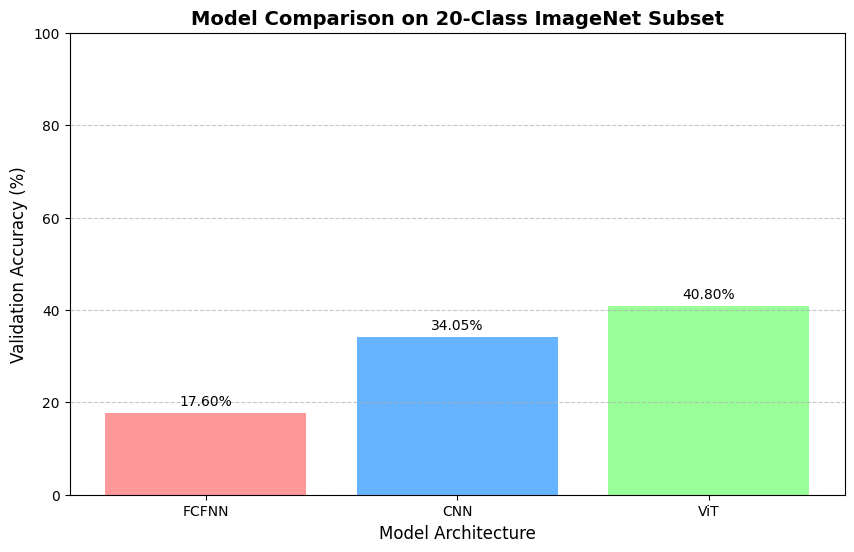

In [ ]:
EPOCHS = 8 # Increase to 5 or 10 for better results if you have time
results = {}

# --- Train FCFNN ---
fcfnn_acc, fcfnn_history = train_model(fcfnn_model, "FCFNN", train_loader, val_loader, epochs=EPOCHS)
results['FCFNN'] = fcfnn_acc

# --- Train CNN ---
cnn_acc, cnn_history = train_model(cnn_model, "Simple CNN", train_loader, val_loader, epochs=EPOCHS)
results['CNN'] = cnn_acc

# --- Train ViT ---
vit_acc, vit_history = train_model(vit_model, "Vision Transformer", train_loader, val_loader, epochs=EPOCHS)
results['ViT'] = vit_acc

# --- Final Comparison ---
print("\n\n================= FINAL RESULTS =================\n")

print(f"{'Model':<25} | {'Final Validation Accuracy (%)':<30}")
print("-" * 60)
for model_name, acc in results.items():
    print(f"{model_name:<25} | {acc:.2f}")

# --- Plotting the results ---
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['#ff9999','#66b3ff','#99ff99'])
plt.xlabel("Model Architecture", fontsize=12)
plt.ylabel("Validation Accuracy (%)", fontsize=12)
plt.title("Model Comparison on 20-Class ImageNet Subset", fontsize=14, weight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.show()